In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [2]:
data = pd.read_csv('noisy_dataset.csv')
data.head()

,Age,Income,Height,Pets,Hobby,RandomScore,Buy_House
0,63,126200,165,Dog,Traveling,61.273929,1
1,20,58607,194,Dog,Traveling,-105.161162,0
2,46,47550,198,NaN,Reading,-23.066379,0
3,52,71366,162,Dog,Traveling,-61.197526,1
4,56,121372,153,Cat,Reading,-85.085226,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          5000 non-null   int64  
 1   Income       5000 non-null   int64  
 2   Height       5000 non-null   int64  
 3   Pets         3282 non-null   object 
 4   Hobby        5000 non-null   object 
 5   RandomScore  5000 non-null   float64
 6   Buy_House    5000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 273.6+ KB


In [4]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,5000.0,NaN,NaN,NaN,43.5932,14.937615,18.0,31.0,43.0,57.0,69.0
Income,5000.0,NaN,NaN,NaN,84769.2102,37663.269954,20000.0,51632.0,83704.5,117799.25,149978.0
Height,5000.0,NaN,NaN,NaN,174.4274,14.323874,150.0,162.0,175.0,187.0,199.0
Pets,3282,2,Cat,1667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hobby,5000,3,Traveling,1697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RandomScore,5000.0,NaN,NaN,NaN,-1.870536,99.817755,-365.568956,-68.284933,-1.592768,66.365399,409.350075
Buy_House,5000.0,NaN,NaN,NaN,0.5314,0.499063,0.0,0.0,1.0,1.0,1.0


#### 2 — Feature-level noise (columns) — how to detect & remove, one-by-one
**A. Manual / domain knowledge drop (fast)**

If you already know certain columns are irrelevant (Height, Pets, Hobby, RandomScore in your dataset), you can drop them:

In [5]:
data_manual = data.drop(columns=["Height","Pets","Hobby","RandomScore"])


**B. Univariate filter methods — measure relevance to the target**

Use statistical measures to score each feature against the target (binary Buy_House).

- Action: drop features with MI ≈ 0 (very near zero).
- Why: mutual information captures nonlinear relationships for both numeric & categorical encoded features.

In [6]:
from sklearn.feature_selection import mutual_info_classif

X = pd.get_dummies(data.drop(columns = "Buy_House"), drop_first = True)
y = data["Buy_House"].astype(int)

mi = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi, index = X.columns).sort_values(ascending= False)
print(mi_series)

Age                0.035910
Income             0.032610
Hobby_Traveling    0.006457
RandomScore        0.004206
Height             0.003817
Pets_Dog           0.000104
Hobby_Reading      0.000000
dtype: float64


In [7]:
## Now delete the columns less having less relevancy

data_mi = data.drop(columns=["Height", "Pets", "Hobby", "RandomScore"])


**C. Correlation for numeric features (simple)**

Action: If absolute correlation is near 0, the numeric feature is probably unimportant.

In [8]:
num = data.select_dtypes(include =[ np.number]).drop(columns="Buy_House")

corr_with_target = num.corrwith(y).sort_values(ascending=False)
print(corr_with_target)

Age            0.192126
Income         0.177889
RandomScore   -0.002046
Height        -0.038634
dtype: float64


**D. Embedded methods — feature importance from a tree**

- Action: Drop features with very low importance (e.g., < 0.01 or rank-based — lowest X features).
- Why: tree models naturally measure how useful a feature was for splitting.

In [10]:
from sklearn.ensemble import RandomForestClassifier

X_enc = X
rf = RandomForestClassifier(n_estimators=200, random_state=0)

rf.fit(X_enc, y)
fi = pd.Series(rf.feature_importances_, index= X_enc.columns).sort_values(ascending=False)
print(fi)

Income             0.307816
Age                0.238731
RandomScore        0.231860
Height             0.171017
Pets_Dog           0.018028
Hobby_Traveling    0.016755
Hobby_Reading      0.015794
dtype: float64


**E. Wrapper methods — recursive feature elimination (if you want the best subset)**

Action: Keeps the best subset according to the estimator and cross-validation (slower but precise).

In [11]:
from sklearn.feature_selection import RFE 
est = RandomForestClassifier(n_estimators=100, random_state=0)
rfe = RFE(est, n_features_to_select=3).fit(X_enc, y)
selected = X_enc.columns[rfe.support_]
print("Selected: ", list(selected))

Selected:  ['Age', 'Income', 'RandomScore']


**Decision rule (practical)**

- If domain knowledge says “irrelevant” → drop immediately.

- Else use MI + RandomForest importance: drop features with MI≈0 and RF importance very small.

- If uncertain, try RFE or keep the feature and test model performance with/without it.

In [12]:
data = data.drop(columns=["Height", "RandomScore", "Pets", "Hobby"])

#### 3 — Instance-level noise (rows): how to identify which rows are distractions

We want rows that hurt the model: duplicates, outliers, mislabeled or ambiguous rows.

**A. Duplicates & trivially-bad rows**

In [14]:
dupes = data[data.duplicated(keep=False)]
print(len(dupes))
data = data.drop_duplicates()

0


**B. Missing Values**

In [15]:
data.isna().sum()

Age          0
Income       0
Buy_House    0
dtype: int64

**C. Simple Outlier detection (numeric features)**

1. **Z-score/IQR**

In [18]:
from scipy import stats
num = data.select_dtypes(include=[np.number]).drop(columns="Buy_House")
z = np.abs(stats.zscore(num, nan_policy='omit'))
outlier_idx_z = np.where((z>3).any(axis= 1))[0]

print(outlier_idx_z)

[]


2. **Isolation Forest (robust, works well)**

In [19]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=0)
iso_pred = iso.fit_predict(num.fillna(num.median()))
outliers_iso = np.where(iso_pred == -1)[0]
print(outliers_iso)

[  77   83  383  486  490  538  612  619  684  704 1125 1204 1368 1401
 1463 1596 1634 1799 1861 1889 2043 2047 2165 2275 2383 2384 2568 2653
 2693 2743 2923 2951 3181 3218 3377 3431 3711 4002 4044 4117 4177 4202
 4210 4572 4586 4614 4757 4802 4902 4960]


In [21]:
outlier_row = data.iloc[outliers_iso]
outlier_row.tail(10)

,Age,Income,Buy_House
4178,69,20503,1
4203,69,143716,0
4211,21,149053,0
4573,18,139856,0
4587,18,28875,1
4615,20,148550,1
4758,22,20453,0
4803,68,147225,1
4903,68,146648,1
4961,69,140156,1


In [22]:
data.to_csv('cleaned_predictHouse.csv', index= False)

In [23]:
df = pd.read_csv('cleaned_predictHouse.csv')
df.head()

,Age,Income,Buy_House
0,63,126200,1
1,20,58607,0
2,46,47550,0
3,52,71366,1
4,56,121372,1


In [24]:
x = pd.get_dummies(df.drop(columns="Buy_House"), drop_first = True)
y = df["Buy_House"]


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
clf = DecisionTreeClassifier(criterion='gini', # or 'entropy'
 max_depth= 5,
 min_samples_split=20, random_state=42                    )

clf.fit(x_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,20
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = clf.predict(x_test)

# Report 
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix : ", cm)

accu_score = accuracy_score(y_test, y_pred)

print(" Accuracy: ", accu_score)


              precision    recall  f1-score   support

           0       0.73      0.62      0.67       469
           1       0.70      0.79      0.75       531

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000

Confusion Matrix :  [[291 178]
 [109 422]]
 Accuracy:  0.713


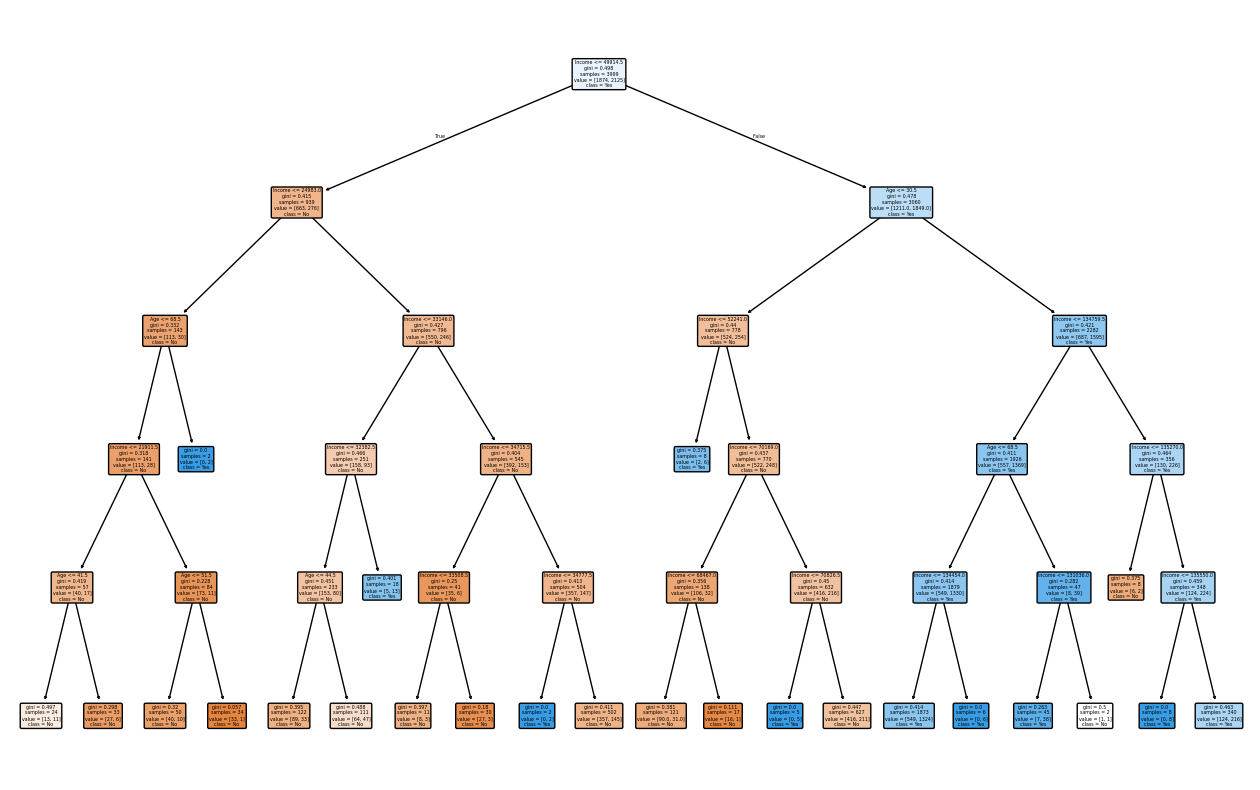

In [29]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plot_tree(clf, feature_names=x.columns, class_names=["No","Yes"], filled=True, rounded=True)
plt.show()


In [30]:
print('Accuracy in Percentage: ', int(accu_score * 100), '%')

Accuracy in Percentage:  71 %


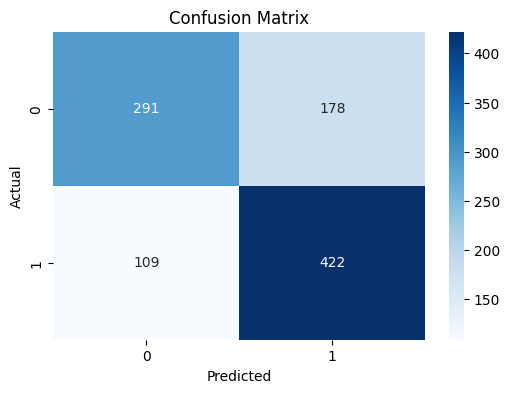

In [35]:
# Example: create confusion matrix dataframe
conf_mat = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
# Plot with seaborn
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

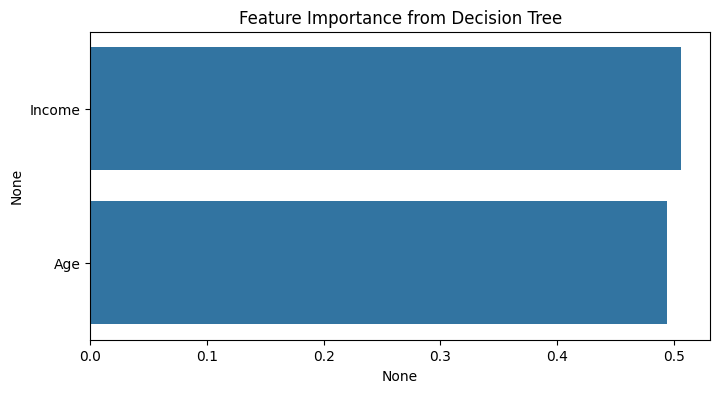

In [37]:
import seaborn as sns

importances = pd.Series(clf.feature_importances_, index=x.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance from Decision Tree")
plt.show()


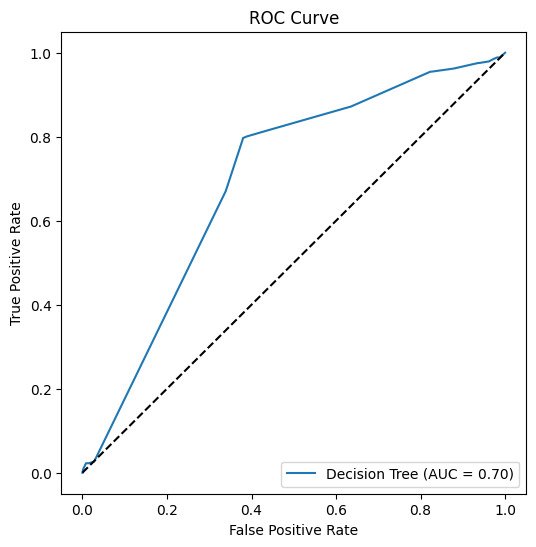

In [39]:
from sklearn.metrics import roc_curve, auc

y_proba = clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="Decision Tree (AUC = %.2f)" % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [40]:
def predict_buy_house(model, age, income, height=170, pets="None", hobby="Reading", randomscore=0.0):
    """
    Predict if a person will buy a house using trained decision tree model.
    
    Parameters:
        model : trained DecisionTreeClassifier
        age (int)
        income (int)
        height (int, optional)
        pets (str, optional)
        hobby (str, optional)
        randomscore (float, optional)
    
    Returns:
        str : "Yes" or "No"
    """
    # Build single-row dataframe
    input_df = pd.DataFrame([{
        "Age": age,
        "Income": income,
        "Height": height,
        "Pets": pets,
        "Hobby": hobby,
        "RandomScore": randomscore
    }])
    
    # One-hot encode with same columns as training set
    input_enc = pd.get_dummies(input_df)
    input_enc = input_enc.reindex(columns=model.feature_names_in_, fill_value=0)
    
    # Prediction
    pred = model.predict(input_enc)[0]
    return "Yes (Will Buy)" if pred == 1 else "No (Won't Buy)"


In [41]:
# Example input
print(predict_buy_house(clf, age=35, income=60000, pets="Dog", hobby="Gaming"))
print(predict_buy_house(clf, age=25, income=30000, pets="Cat", hobby="Reading"))


Yes (Will Buy)
No (Won't Buy)
